In [84]:
import pandas as pd
import itertools
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from lightgbm import LGBMClassifier
import os
import seaborn as sns
from wordcloud import WordCloud

In [85]:
df=pd.read_csv('malicious_phish.csv')
print(df.shape)
df.head()

(651191, 2)


,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [86]:
df.type.value_counts()

type
benign        428103
defacement     96457
phishing       94111
malware        32520
Name: count, dtype: int64

# Feature Engineering

In [88]:
import re
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6
    if match:
        return 1
    else:
        return 0
df['use_of_ip']=df['url'].apply(lambda i:having_ip_address(i))

In [89]:
from urllib.parse import urlparse
def abnormal_url(url):
    hostname=urlparse(url).hostname
    hostname=str(hostname)
    match=re.search(hostname,url)
    if match:
        return 1
    else:
        return 0;
df['abnormal_url'] = df['url'].apply(lambda i: abnormal_url(i))

In [90]:
from googlesearch import search

In [91]:
def google_index(url):
    try:
        site=search(url,5)
        return 1 if site else 0
    except:
        return 0
df['google_index']=df['url'].apply(lambda i: google_index(i))

In [92]:
def count_dot(url):
    count_dot=url.count('.')
    return count_dot
df['count.']=df['url'].apply(lambda i:count_dot(i))

In [93]:
df.head()

,url,type,use_of_ip,abnormal_url,google_index,count.
0,br-icloud.com.br,phishing,0,0,1,2
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,1,2
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,1,2
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,1,3
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,1,2


In [94]:
def count_www(url):
    return url.count('www')
df['count-www']=df['url'].apply(lambda i:count_www(i))

def count_atrate(url):
    return url.count('@')
df['count@']=df['url'].apply(lambda i:count_atrate(i))

def no_of_dir(url):
    urldir=urlparse(url).path
    return urldir.count('/')

df['count_dir']=df['url'].apply(lambda i:no_of_dir(i))

def no_of_embed(url):
    urldir=urlparse(url).path
    return urldir.count('//')

df['count_embed_domain']=df['url'].apply(lambda i: no_of_embed(i))

def shortening_service(url):
    match = re.search(r'bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      r'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      r'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      r'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      r'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      r'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      r'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      r'tr\.im|link\.zip\.net',
                      url)
    return 1 if match else 0

df['short_url'] = df['url'].apply(shortening_service)

def count_https(url):
    return url.count('https')

df['https_count']=df['url'].apply(lambda i:count_https(i))

def count_http(url):
    return url.count('http')

df['count_http']=df['url'].apply(lambda i:count_http(i))

def count_per(url):
    return url.count("%")
df['count%']=df['url'].apply(lambda i: count_per(i))

def count_ques(url):
    return url.count('?')

df['count?']=df['url'].apply(lambda i:count_ques(i))

def count_hyphen(url):
    return url.count('-')

df['count-']=df['url'].apply(lambda i:count_hyphen(i))

def count_equal(url):
    return url.count('=')

df['count=']=df['url'].apply(lambda i: count_equal(i))

def url_length(url):
    return len(str(url))

df['url_length']=df['url'].apply(lambda i: url_length(i))

def hostname_length(url):
    return len(urlparse(url).netloc)

df['hostname_length']=df['url'].apply(lambda i: hostname_length(i))

def sus_words(url):
    match=re.search('PayPal|login|signin|bank|account|update|free|lucky|service|bonus|ebayisapi|webscr',
                      url)
    if match:
        return 1
    else:
        return 0
df['sus_url']=df['url'].apply(lambda i:sus_words(i))

def digit_count(url):
    digits=0
    for i in url:
        if i.isnumeric():
            digits=digits+1
    return digits

df['count-digits']=df['url'].apply(lambda i: digit_count(i))

def letter_count(url):
    letters=0
    for i in url:
        if i.isalpha():
            letters=letters+1
    return letters

df['count-letters']=df['url'].apply(lambda i: letter_count(i))


In [95]:
df.head()

,url,type,use_of_ip,abnormal_url,google_index,count.,count-www,count@,count_dir,count_embed_domain,...,count_http,count%,count?,count-,count=,url_length,hostname_length,sus_url,count-digits,count-letters
0,br-icloud.com.br,phishing,0,0,1,2,0,0,0,0,...,0,0,0,1,0,16,0,0,0,13
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,1,2,0,0,2,0,...,0,0,0,0,0,35,0,0,1,29
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,1,2,0,0,3,0,...,0,0,0,0,0,31,0,0,1,25
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,1,3,1,0,1,0,...,1,0,1,1,4,88,21,0,7,63
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,1,2,0,0,1,0,...,1,0,1,1,3,235,23,0,22,199


In [96]:
from urllib.parse import urlparse
from tld import get_tld
import os.path

def fd_length(url):
    urlpath=urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return -1

df['fd_length']=df['url'].apply(lambda i:fd_length(i))

df['tld']=df['url'].apply(lambda i:get_tld(i,fail_silently=True))

def tld_length(tld):
    try:
        return len(tld)
    except:
        return -1

df['tld_length']=df['tld'].apply(lambda i: tld_length(i))


In [97]:
df.head()

,url,type,use_of_ip,abnormal_url,google_index,count.,count-www,count@,count_dir,count_embed_domain,...,count-,count=,url_length,hostname_length,sus_url,count-digits,count-letters,fd_length,tld,tld_length
0,br-icloud.com.br,phishing,0,0,1,2,0,0,0,0,...,1,0,16,0,0,0,13,-1,None,-1
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,1,2,0,0,2,0,...,0,0,35,0,0,1,29,5,None,-1
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,1,2,0,0,3,0,...,0,0,31,0,0,1,25,7,None,-1
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,1,3,1,0,1,0,...,1,4,88,21,0,7,63,9,be,2
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,1,2,0,0,1,0,...,1,3,235,23,0,22,199,9,net,3


In [98]:
df=df.drop("tld",axis=1)

In [99]:
df.columns

Index(['url', 'type', 'use_of_ip', 'abnormal_url', 'google_index', 'count.',
       'count-www', 'count@', 'count_dir', 'count_embed_domain', 'short_url',
       'https_count', 'count_http', 'count%', 'count?', 'count-', 'count=',
       'url_length', 'hostname_length', 'sus_url', 'count-digits',
       'count-letters', 'fd_length', 'tld_length'],
      dtype='object')

In [100]:
df['type'].value_counts()

type
benign        428103
defacement     96457
phishing       94111
malware        32520
Name: count, dtype: int64

# Label Encoding

In [102]:
from sklearn.preprocessing import LabelEncoder

lb_make=LabelEncoder()
df['type_code']=lb_make.fit_transform(df['type'])
df['type_code'].value_counts()

type_code
0    428103
1     96457
3     94111
2     32520
Name: count, dtype: int64

In [103]:
x= df.drop(columns=['type_code', 'url', 'type'])

y=df['type_code']

In [104]:
x.head()

,use_of_ip,abnormal_url,google_index,count.,count-www,count@,count_dir,count_embed_domain,short_url,https_count,...,count?,count-,count=,url_length,hostname_length,sus_url,count-digits,count-letters,fd_length,tld_length
0,0,0,1,2,0,0,0,0,0,0,...,0,1,0,16,0,0,0,13,-1,-1
1,0,0,1,2,0,0,2,0,0,0,...,0,0,0,35,0,0,1,29,5,-1
2,0,0,1,2,0,0,3,0,0,0,...,0,0,0,31,0,0,1,25,7,-1
3,0,1,1,3,1,0,1,0,0,0,...,1,1,4,88,21,0,7,63,9,2
4,0,1,1,2,0,0,1,0,0,0,...,1,1,3,235,23,0,22,199,9,3


In [105]:
y.head()

0    3
1    0
2    0
3    1
4    1
Name: type_code, dtype: int32

# Train Test Split

In [107]:
x_train,x_test,y_train,y_test= train_test_split(x,y,stratify=y,test_size=0.2,shuffle=True,random_state=5)

# Model Building

## 1. Random Forest

In [110]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

rf=RandomForestClassifier(n_estimators=100,max_features='sqrt')
rf.fit(x_train,y_train)

y_pred_rf=rf.predict(x_test)
print(classification_report(y_test,y_pred_rf,target_names=['benign','defacement','phishing','malware']))

score=metrics.accuracy_score(y_test,y_pred_rf)
print("accuracy:  %0.3f" % score)

              precision    recall  f1-score   support

      benign       0.97      0.98      0.98     85621
  defacement       0.98      0.99      0.99     19292
    phishing       0.99      0.94      0.97      6504
     malware       0.91      0.86      0.88     18822

    accuracy                           0.97    130239
   macro avg       0.96      0.95      0.95    130239
weighted avg       0.97      0.97      0.97    130239

accuracy:  0.966


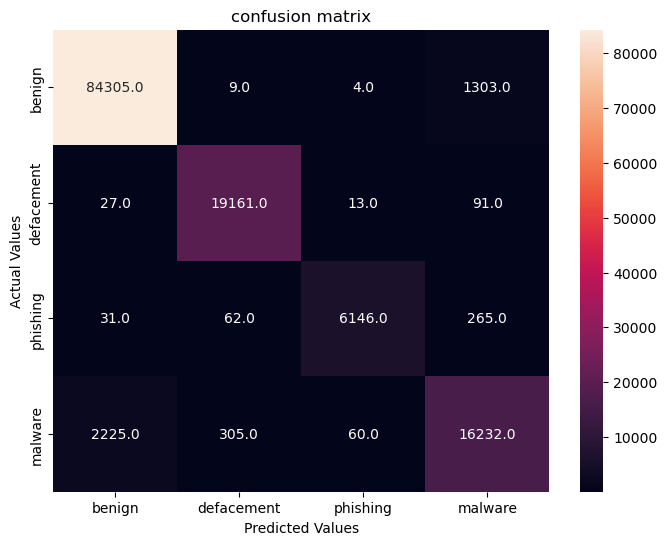

In [111]:
cm=confusion_matrix(y_test,y_pred_rf)

cm_df=pd.DataFrame(cm,index=['benign','defacement','phishing','malware'],
                  columns=['benign','defacement','phishing','malware'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df,annot=True,fmt=".1f")
plt.title('confusion matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

<Axes: >

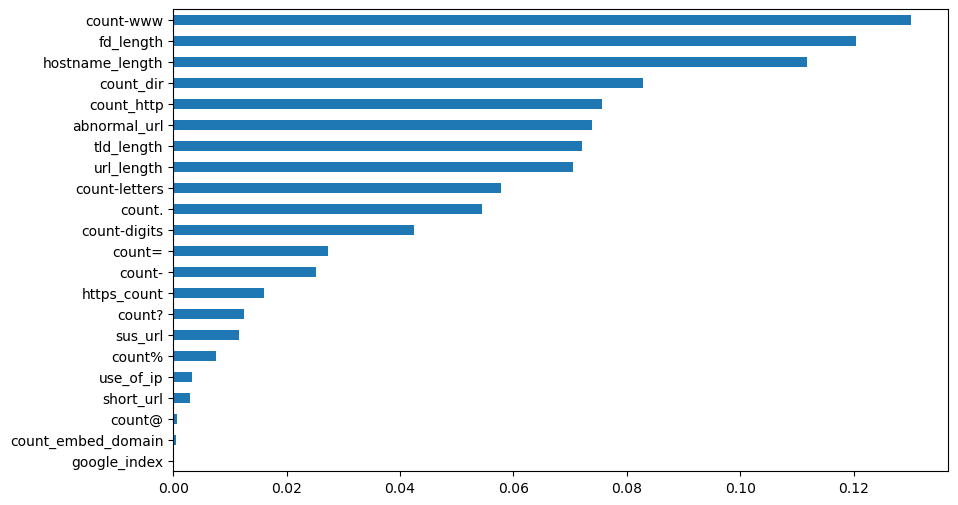

In [112]:
feat_importance=pd.Series(rf.feature_importances_,index=x_train.columns)
feat_importance.sort_values().plot(kind="barh",figsize=(10,6))

## 2. Light GBM Classifier

In [114]:
lgb=LGBMClassifier(objective='multiclass',boosting_type='gbdt',n_jobs=5,
                   verbose=-1,random_state=5)
lgb_c=lgb.fit(x_train,y_train)
y_pred_lgb=lgb_c.predict(x_test)
print(classification_report(y_test,y_pred_lgb,target_names=['benign','defacement','phishing','malware']))

score=metrics.accuracy_score(y_test,y_pred_lgb)
print("accuracy: %0.3f" % score)


              precision    recall  f1-score   support

      benign       0.97      0.99      0.98     85621
  defacement       0.96      0.99      0.98     19292
    phishing       0.97      0.91      0.94      6504
     malware       0.90      0.83      0.86     18822

    accuracy                           0.96    130239
   macro avg       0.95      0.93      0.94    130239
weighted avg       0.96      0.96      0.96    130239

accuracy: 0.959


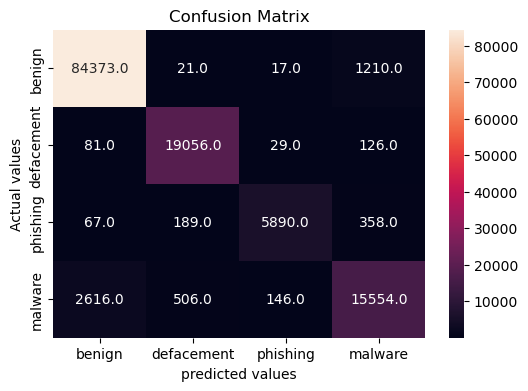

In [115]:
cm=confusion_matrix(y_test,y_pred_lgb)

cm_df=pd.DataFrame(cm,
                   index=['benign','defacement','phishing','malware'],
                   columns=['benign','defacement','phishing','malware'])

plt.figure(figsize=(6,4))
sns.heatmap(cm_df,annot=True,fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actual values')
plt.xlabel('predicted values')
plt.show()

<Axes: >

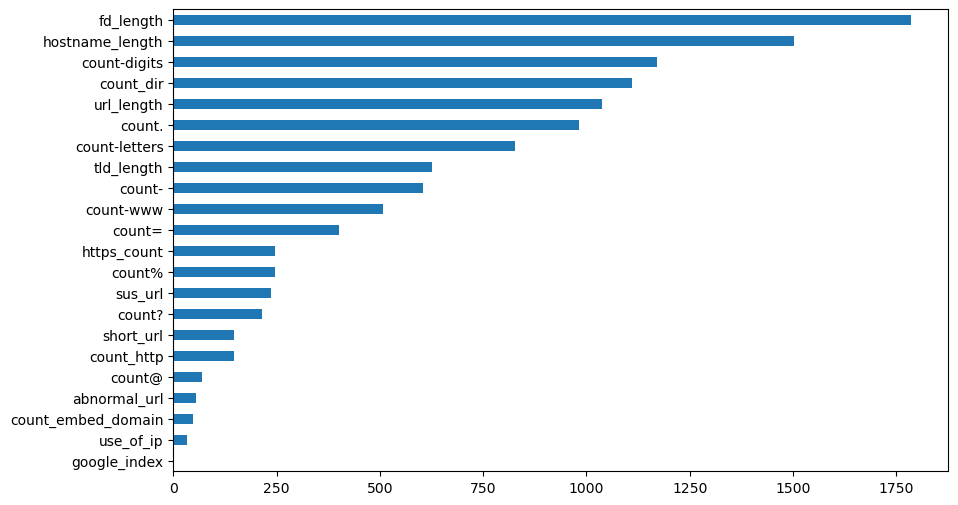

In [116]:
feat_importances=pd.Series(lgb.feature_importances_,index=x_train.columns)
feat_importances.sort_values().plot(kind="barh",figsize=(10,6))


## 3. XGboost

In [118]:
xgb_c=xgb.XGBClassifier(n_estimators=100)
xgb_c.fit(x_train,y_train)
y_pred_x=xgb_c.predict(x_test)
print(classification_report(y_test,y_pred_x,target_names=['benign','defacement','phishing','malware']))

score=metrics.accuracy_score(y_test,y_pred_x)
print("accuracy: %0.3f" %score)

              precision    recall  f1-score   support

      benign       0.97      0.99      0.98     85621
  defacement       0.97      0.99      0.98     19292
    phishing       0.98      0.92      0.95      6504
     malware       0.91      0.83      0.87     18822

    accuracy                           0.96    130239
   macro avg       0.96      0.93      0.94    130239
weighted avg       0.96      0.96      0.96    130239

accuracy: 0.962


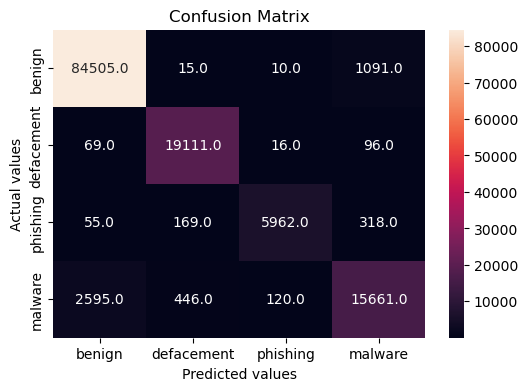

In [119]:
cm=confusion_matrix(y_test,y_pred_x)
cm_df=pd.DataFrame(cm,
                  index=['benign','defacement','phishing','malware'],
                  columns=['benign','defacement','phishing','malware'])
plt.figure(figsize=(6,4))
sns.heatmap(cm_df,annot=True,fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actual values')
plt.xlabel('Predicted values')
plt.show()

# Prediction

In [121]:
def main(url):
    status=[]
    status.append(having_ip_address(url))
    status.append(abnormal_url(url))
    status.append(google_index(url))
    status.append(count_dot(url))
    status.append(count_www(url))
    status.append(count_atrate(url))
    status.append(no_of_dir(url))
    status.append(no_of_embed(url))
    
    status.append(shortening_service(url))
    status.append(count_https(url))
    status.append(count_http(url))
    
    status.append(count_per(url))
    status.append(count_ques(url))
    status.append(count_hyphen(url))
    status.append(count_equal(url))
    
    status.append(url_length(url))
    status.append(hostname_length(url))
    status.append(sus_words(url))
    status.append(digit_count(url))
    status.append(letter_count(url))
    status.append(fd_length(url))
    tld = get_tld(url,fail_silently=True)
      
    status.append(tld_length(tld))

    return status

In [122]:
feat_names = [
    'use_of_ip', 'abnormal_url', 'google_index', 'count.', 'count-www', 'count@',
    'count_dir', 'count_embed_domain', 'short_url', 'https_count', 'count_http',
    'count%', 'count?', 'count-', 'count=', 'url_length', 'hostname_length',
    'sus_url', 'count-digits', 'count-letters', 'fd_length', 'tld_length'
]

def get_prediction_from_url(test_url):
    features_list = main(test_url)
    
    features_df = pd.DataFrame([features_list], columns=feat_names) 
    
    pred = rf.predict(features_df) 
    
    label=int(pred[0])
    
    if  label== 0:
        return "SAFE"
    elif label== 1:
        return "DEFACEMENT"
    elif label==2:
        return "MALWARE"
    elif label==3:
        return "PHISHNG"
    else:
        return "UNKNOWN LABEL"

In [169]:
url='signin.eby.de.zukruygxctzmmqi.civpro.co.za'
print(get_prediction_from_url(url))

PHISHNG


In [163]:
df.head(30)

,url,type,use_of_ip,abnormal_url,google_index,count.,count-www,count@,count_dir,count_embed_domain,...,count-,count=,url_length,hostname_length,sus_url,count-digits,count-letters,fd_length,tld_length,type_code
0,br-icloud.com.br,phishing,0,0,1,2,0,0,0,0,...,1,0,16,0,0,0,13,-1,-1,3
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,1,2,0,0,2,0,...,0,0,35,0,0,1,29,5,-1,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,1,2,0,0,3,0,...,0,0,31,0,0,1,25,7,-1,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,1,3,1,0,1,0,...,1,4,88,21,0,7,63,9,2,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,1,2,0,0,1,0,...,1,3,235,23,0,22,199,9,3,1
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign,0,1,1,2,0,0,3,0,...,16,0,118,11,0,1,93,1,3,0
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign,0,0,1,2,0,0,6,0,...,1,0,45,0,0,4,31,3,-1,0
7,yourbittorrent.com/?q=anthony-hamilton-soulife,benign,0,0,1,1,0,0,1,0,...,2,1,46,0,0,0,40,0,-1,0
8,http://www.pashminaonline.com/pure-pashminas,defacement,0,1,1,2,1,0,1,0,...,1,0,44,22,0,0,37,14,3,1
9,allmusic.com/album/crazy-from-the-heat-r16990,benign,0,0,1,1,0,0,2,0,...,4,0,45,0,0,5,33,5,-1,0


In [125]:
import joblib

joblib.dump(xgb_c, 'model.pkl')

['model.pkl']

In [126]:
!pip show scikit-learn

Name: scikit-learn
Version: 1.3.2
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: C:\Users\ravib\anaconda3\Lib\site-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: imbalanced-learn
